In [2]:
import gymnasium as gym

from skimage import transform # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
obs, _ = env.reset()

Preprocess Frames

In [8]:
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, [110,84])
    
    return preprocessed_frame # 110x84x1 frame

(110, 84)


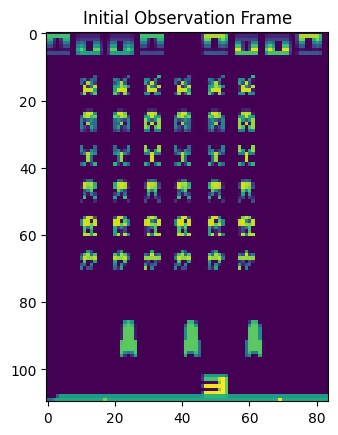

In [13]:
processed_obs = preprocess_frame(obs)
print(processed_obs.shape)
plt.imshow(processed_obs)
# plt.imshow(obs)
plt.title("Initial Observation Frame")
plt.show()

Stack Frames: Motion

In [17]:
def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=int) for _ in range(3)], maxlen=3)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

In [22]:
states, frames = stack_frames([], obs, True)
print(states.shape)

(110, 84, 3)


HP

In [23]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 3]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 8 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 50            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 3                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

DQN

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
            )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x)
        conv_out = conv_out.view(conv_out.size(0), -1)
        return self.fc(conv_out)

Exp Replay

In [24]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

Train

In [ ]:
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]
                
                
    return action, explore_probability